<a href="https://colab.research.google.com/github/Carlos-Rodero/kduino_data_analysis_notebook/blob/main/Kduino_Data_Analysis_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mooda===1.12.0

import mooda as md
import pandas as pd
import numpy as np
import glob
import yaml
import os
import re
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
from scipy import stats, interpolate
from io import StringIO
from datetime import datetime
from google.colab import files

<p><img alt="logo" height="150px" src='https://drive.google.com/uc?export=view&id=11Swg70eHalalGMv8HemoK6l7qu3XRuLC' align="center" hspace="10px" vspace="0px"/></p>
<h1><b>KdUINO Data Analysis Notebook</b></h1>

The KdUINO Data Analysis Notebook is a Jupyter Notebook hosted by Google Colab designed to analyze data files from [KdUINO](https://monocle-h2020.eu/Sensors_and_services/KdUINO) instrumentation. Also, provide methods to generate plots and convert data files in netCDF and CSV format.</br>This Notebook works with different versions of KdUINO:
*   KduPRO
*   KduSTICK
*   KduMOD Professional
*   KduMOD Low-Cost
</br>

---

<p><img alt="logo" height="100px" src='https://git.csic.es/36579996Z/kduino-data-analysis/-/raw/master/docs/img_docs/logo.png' align="center" hspace="10px" vspace="0px"/></p>

This project has received funding from the European Union's Horizon 2020 research and innovation programme under grant agreement No 776480 ([MONOCLE](https://monocle-h2020.eu/)).

# Select KdUINO
Please select your KdUINO instrument:

In [2]:
#@title Select KdUINO { run: "auto", display-mode: "form" }
kduino = "KduPRO" #@param ["KduPRO", "KduSTICK", "KduMOD Professional", "KduMOD Low-Cost", "KdUINO"]

# Upload Files

Please upload the files from your KdUINO instrument:

In [3]:
uploaded = files.upload()

Saving 2022-04-19_buoy2_Brazil_Davi house test_1.00.txt to 2022-04-19_buoy2_Brazil_Davi house test_1.00.txt
Saving 2022-04-19_buoy2_Brazil_Davi house test_2.00.txt to 2022-04-19_buoy2_Brazil_Davi house test_2.00.txt
Saving 2022-04-19_buoy2_Brazil_Davi house test_4.00.txt to 2022-04-19_buoy2_Brazil_Davi house test_4.00.txt


# Configuration

Please configure the time of the sample.

In [4]:
#@title Configuration start and stop { run: "auto", display-mode: "form" }

date_start = '2022-04-19' #@param {type:"date"}
time_start = '19:20:00' #@param {type:"string"}
date_stop = '2022-04-19' #@param {type:"date"}
time_stop = '20:10:00' #@param {type:"string"}

pre_datetime_start = date_start + "Z" + time_start + "T+00:00"
pre_datetime_stop = date_stop + "Z" + time_stop + "T+00:00"

datetime_start = datetime.fromisoformat(pre_datetime_start)
datetime_stop = datetime.fromisoformat(pre_datetime_stop)

# Analysis

Analysis of the KdUINO instrument.

KduPRO
2022-04-19 19:20:00+00:00
2022-04-19 20:10:00+00:00


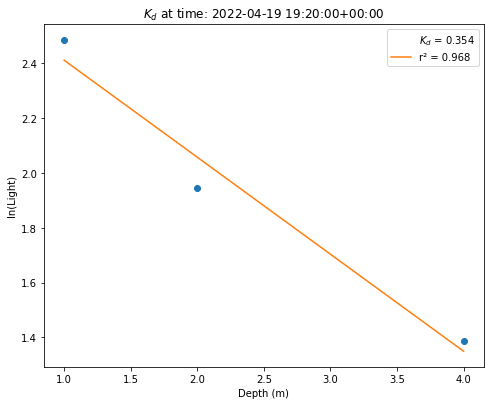

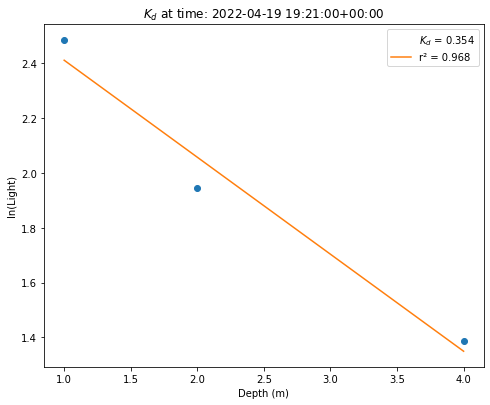

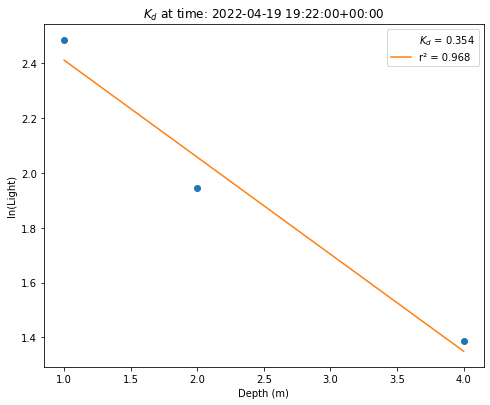

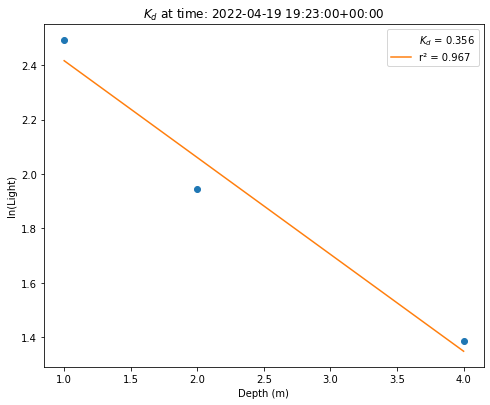

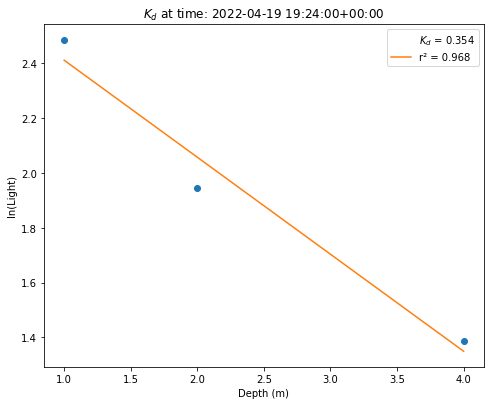

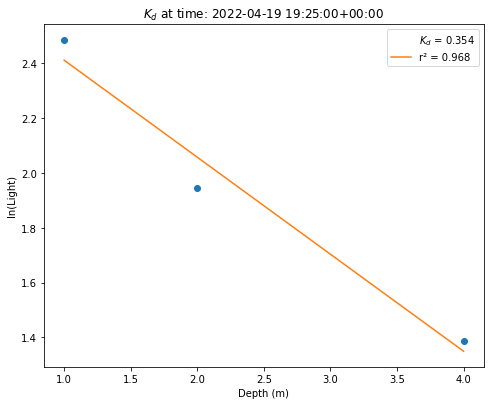

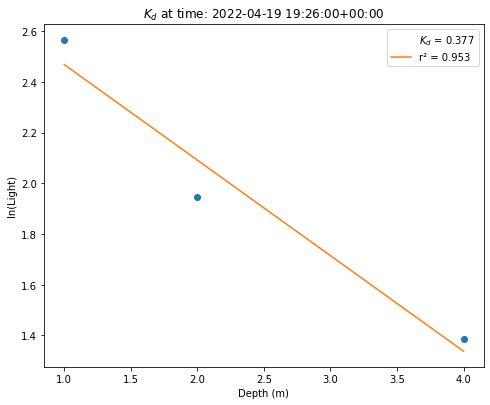

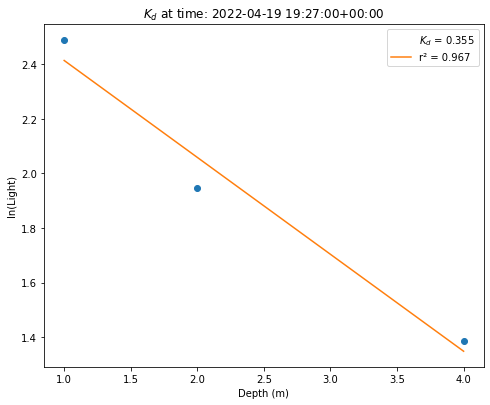

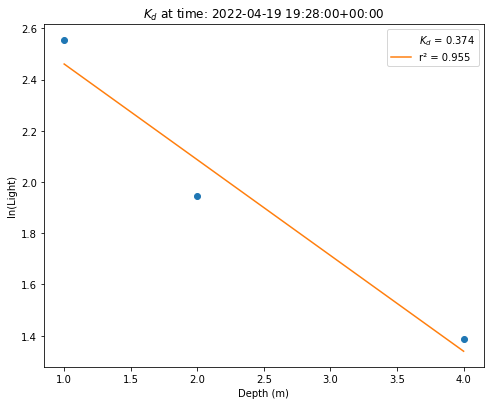

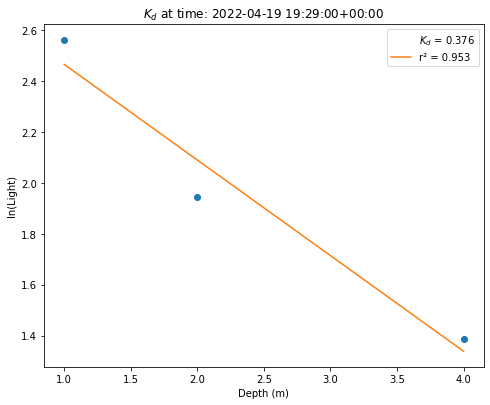

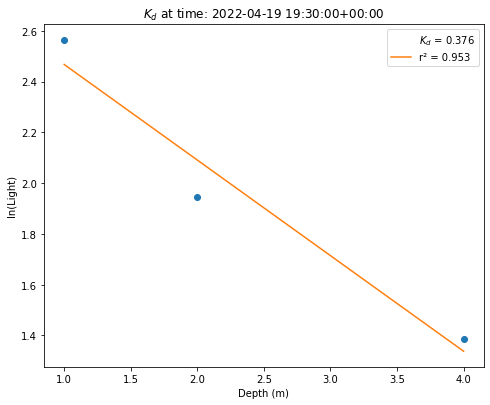

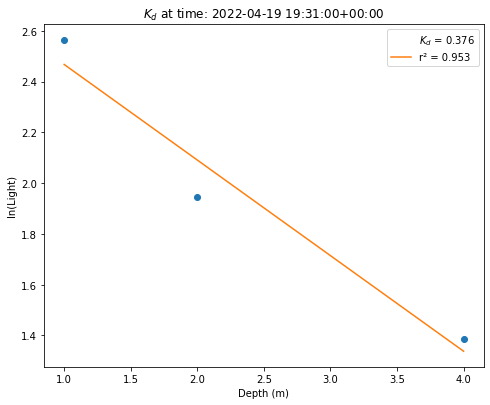

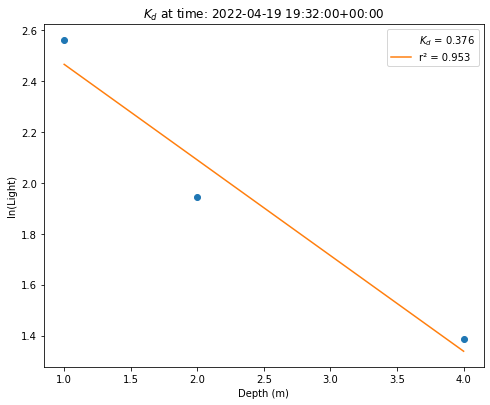

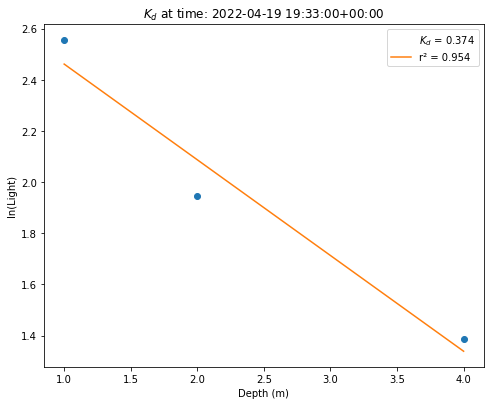

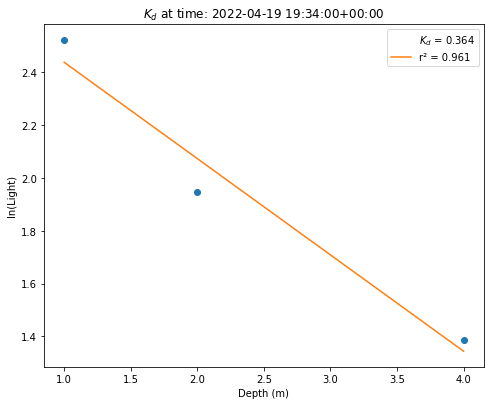

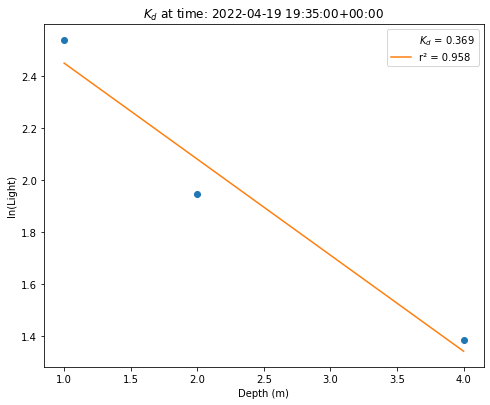

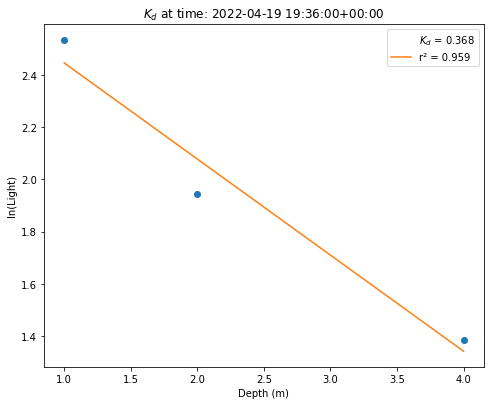

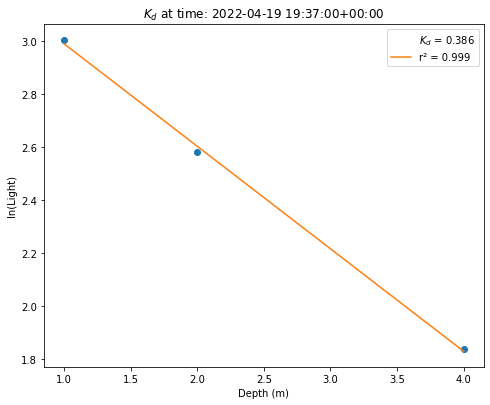

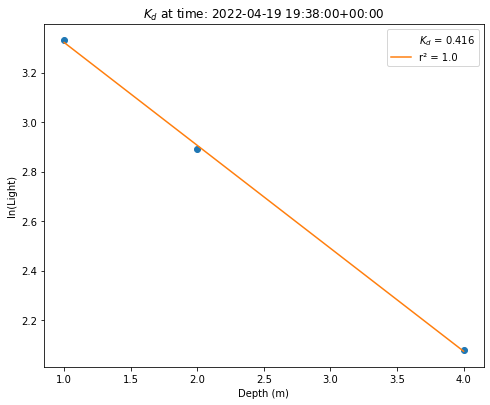

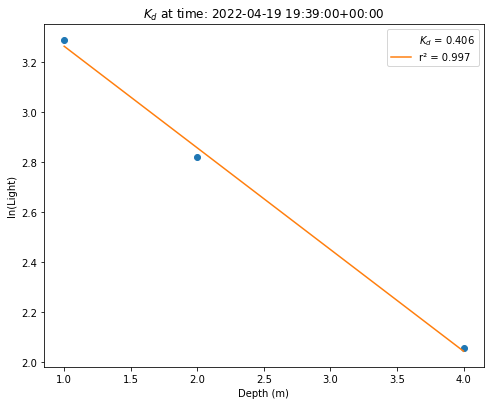

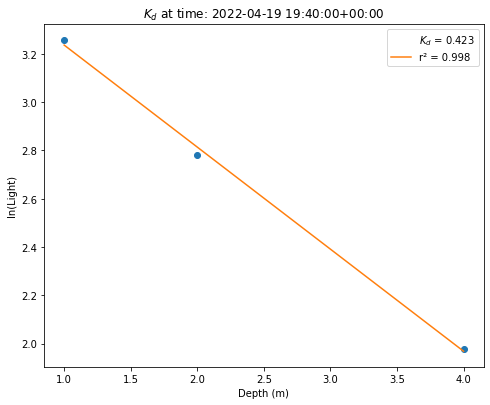

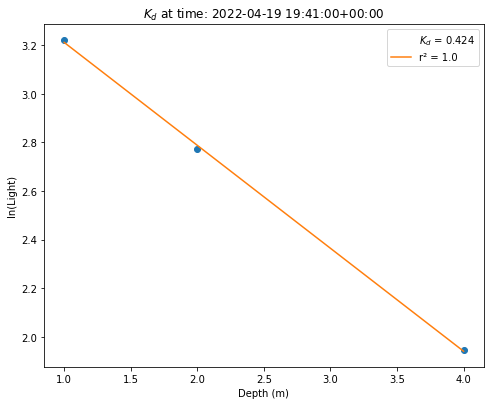

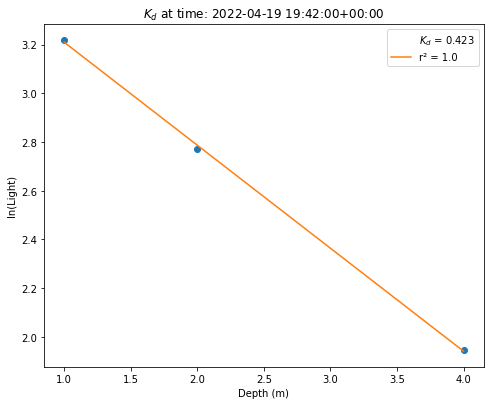

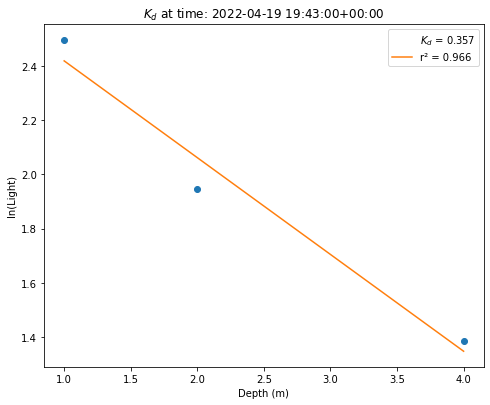

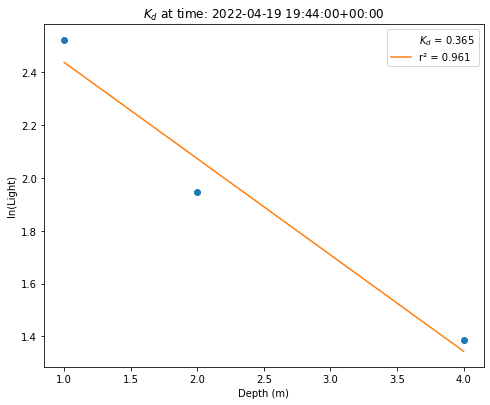

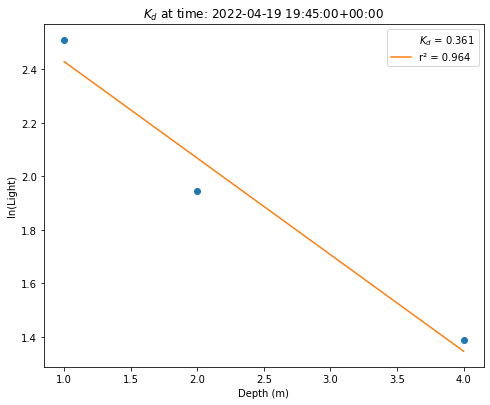

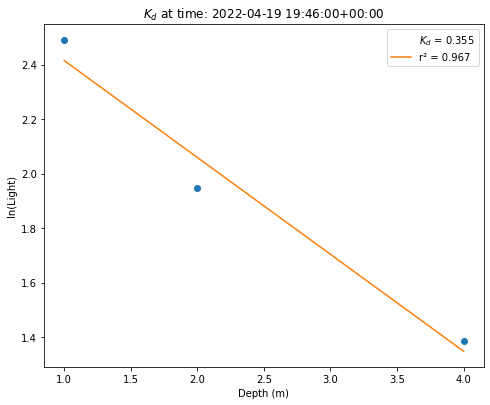

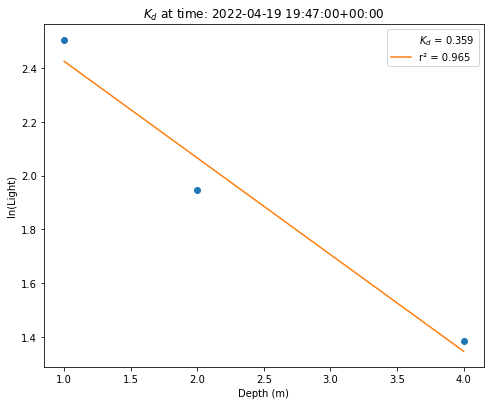

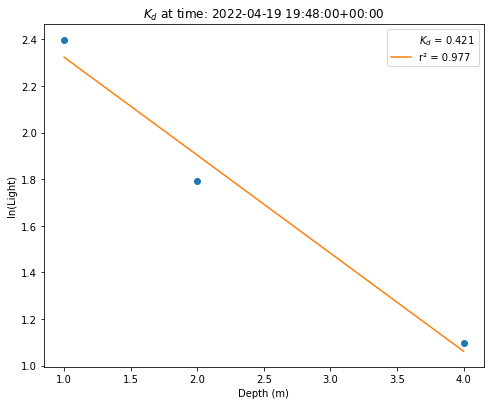

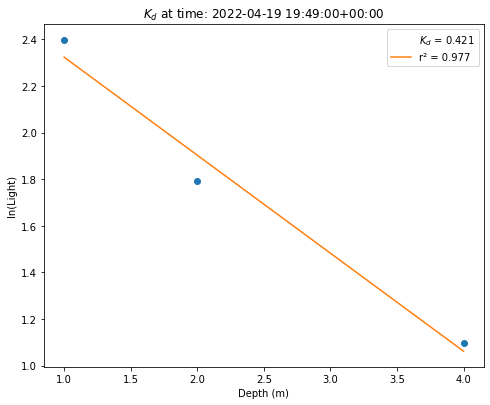

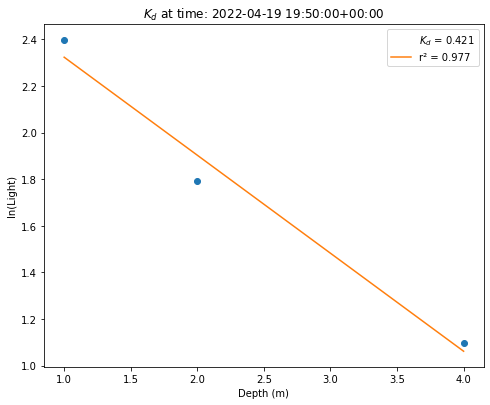

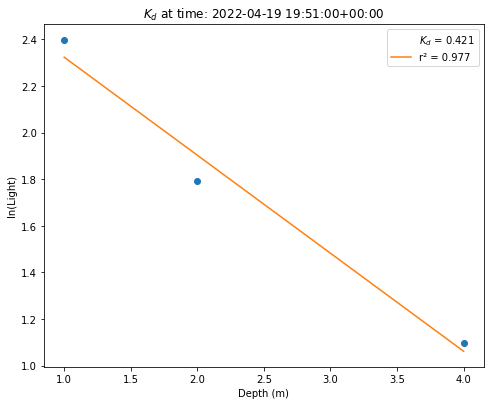

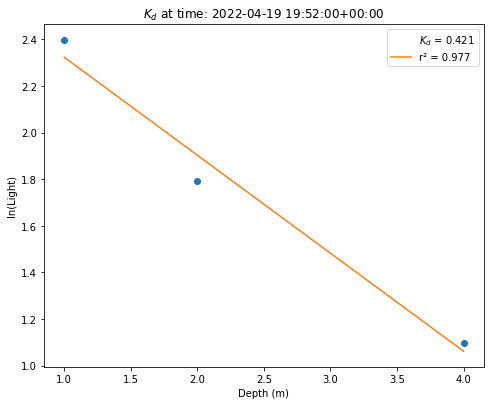

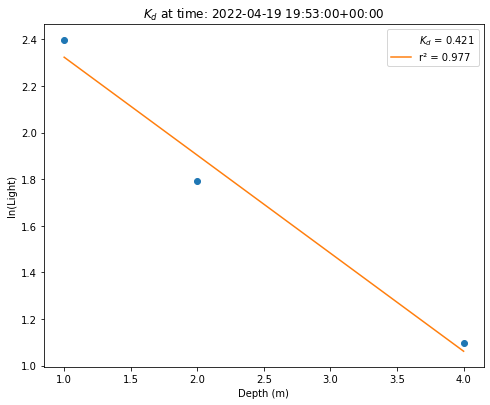

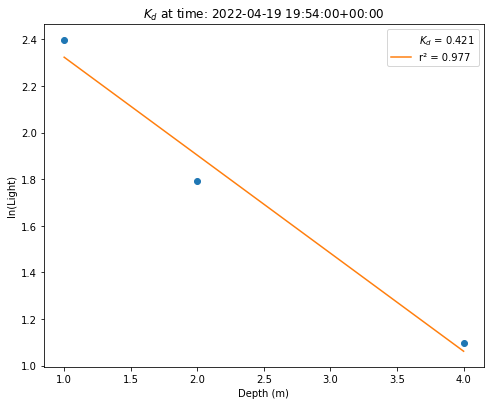

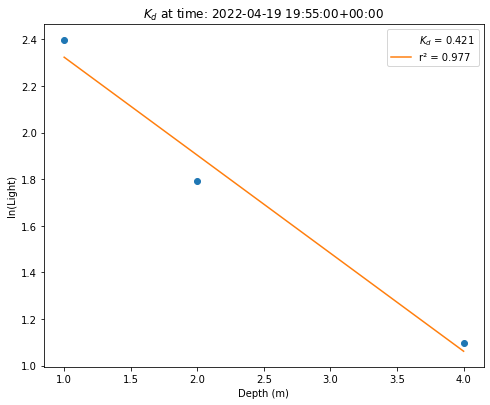

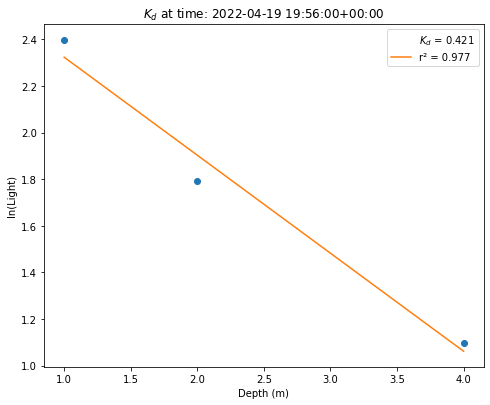

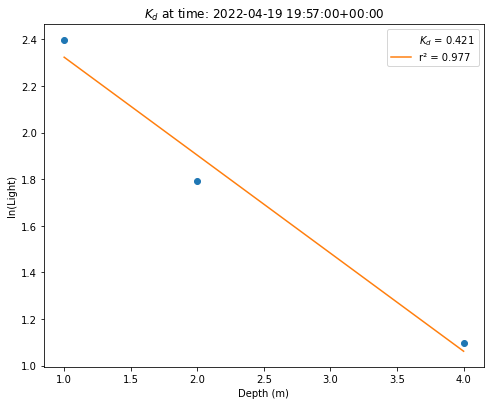

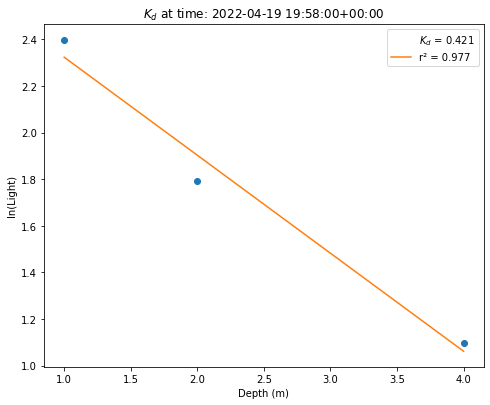

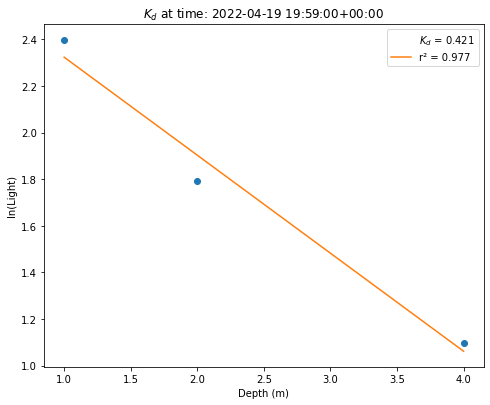

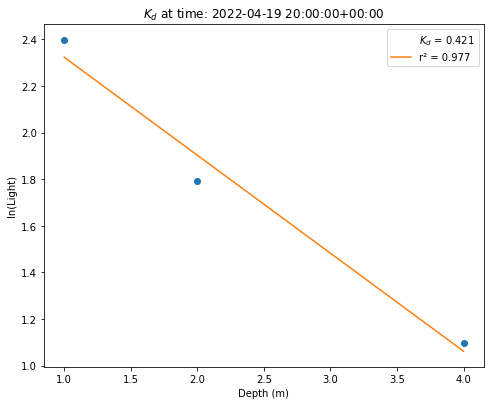

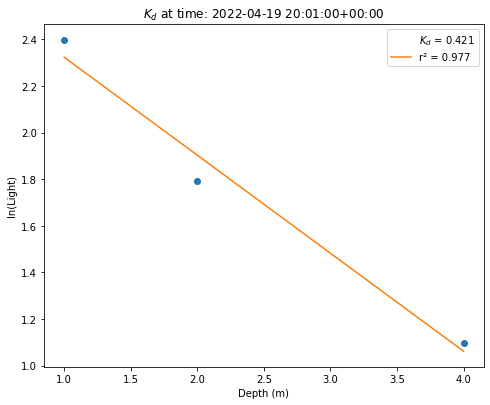

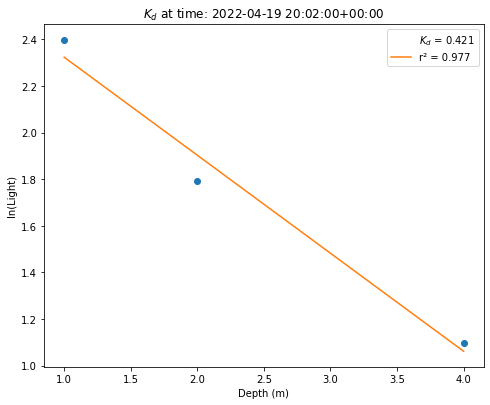

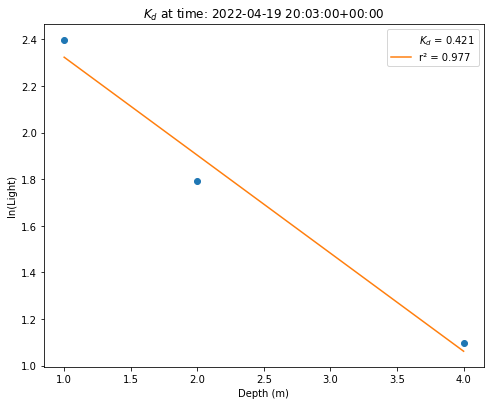

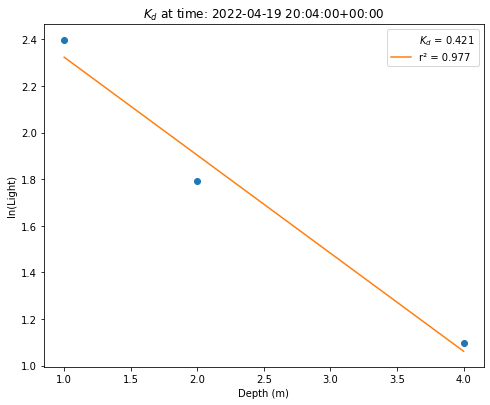

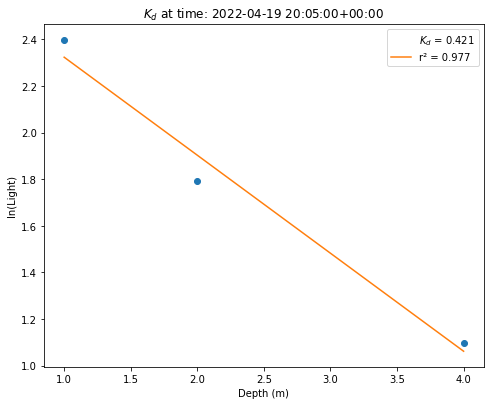

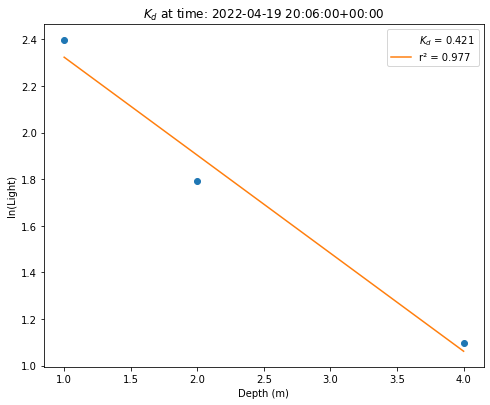

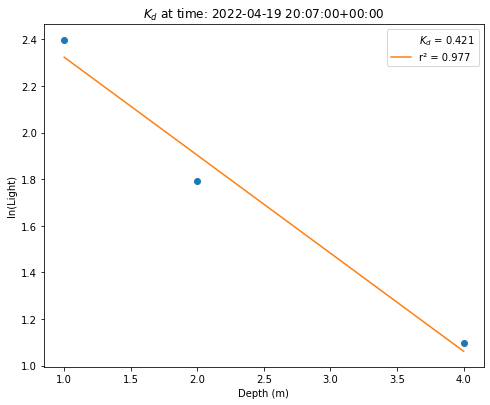

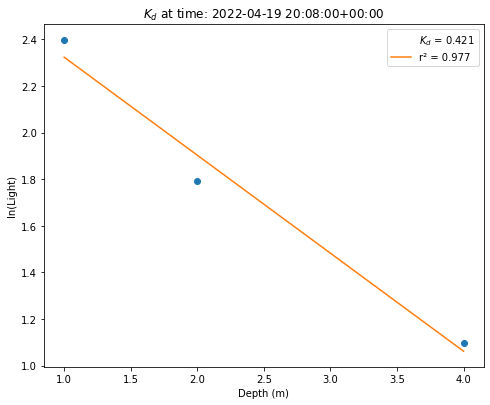

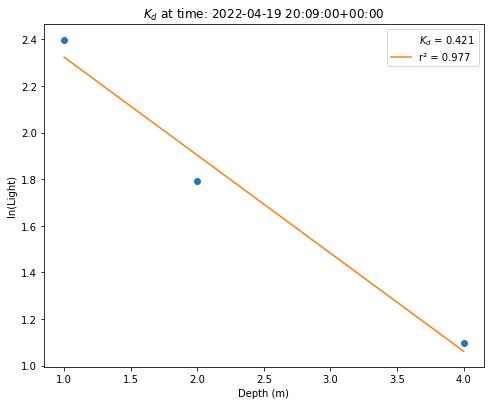

                           CLEAR_1.00  CLEAR_2.00  CLEAR_4.00        Kd  \
TIME                                                                      
2022-04-19 19:20:00+00:00   12.000000        7.00    4.000000  0.353862   
2022-04-19 19:21:00+00:00   12.000000        7.00    4.000000  0.353862   
2022-04-19 19:22:00+00:00   12.000000        7.00    4.000000  0.353862   
2022-04-19 19:23:00+00:00   12.100000        7.00    4.000000  0.356233   
2022-04-19 19:24:00+00:00   12.000000        7.00    4.000000  0.353862   
2022-04-19 19:25:00+00:00   12.000000        7.00    4.000000  0.353862   
2022-04-19 19:26:00+00:00   13.000000        7.00    4.000000  0.376731   
2022-04-19 19:27:00+00:00   12.050000        7.00    4.000000  0.355050   
2022-04-19 19:28:00+00:00   12.866667        7.00    4.000000  0.373786   
2022-04-19 19:29:00+00:00   12.966667        7.00    4.000000  0.375998   
2022-04-19 19:30:00+00:00   12.983333        7.00    4.000000  0.376365   
2022-04-19 19:31:00+00:00

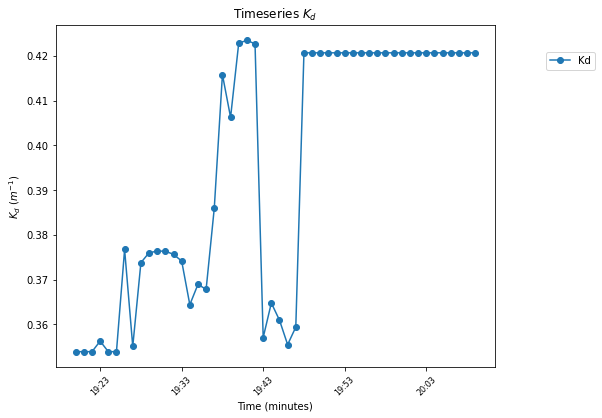



Plot time series Kd PAR with coefficient of determination r2


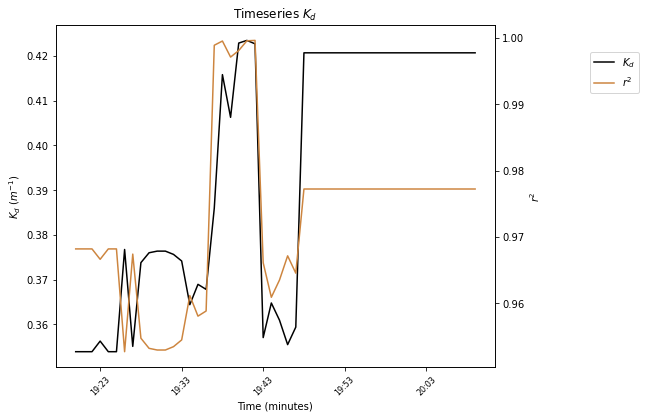


Analysis finished


In [22]:
#@title Code

def analysis_kduino():  
  # Function to analyse data from KdUINO to obtain Kd  
  if kduino == 'KduPRO':    
    print("KduPRO")    
    print(datetime_start)    
    print(datetime_stop)
    
    # Definitions for regular expression paterns    
    start_string_metadata = r"METADATA"    
    stop_string_metadata = r"DATA"    
    start_string_data = r"\bDATA"    
    stop_string_data = r"METADATA"    
    last_start_string_data = r"\bDATA"    
    end_string_data = r'$(?![\r\n])'
    
    metadata_patron = re.compile(r'{}(?P<length>)\s*(?P<table>[\s\S]*?){}'.format(
        start_string_metadata, stop_string_metadata))    
    data_patron = re.compile(r'{}(?P<length>)\s*(?P<table>[\s\S]*?){}'.format(        
        start_string_data, stop_string_data))        
    last_data_patron = re.compile(r'{}(?P<length>)\s*(?P<table>[\s\S]*?){}'.format(        
        last_start_string_data, end_string_data))
    
    selected_info = ""    
    metadata_list = []    
    metadata = {}    
    data_list = []    
    kdupro_list = []        
    
    for k, v in uploaded.items():      
      # print(k)      
      # print(v)      
      
      with open(k) as reader:        
        content = reader.read()        
        # print(content)        
        
        # Regular expression to find the metadata patron        
        for m in re.finditer(metadata_patron, content):          
          selected_info = m.group('table')     
          ''' index_last_metadata = selected_info.rfind('METADATA')
          selected_info_last_metadata = selected_info[index_last_metadata:]
          print(selected_info_last_metadata)
          print(selected_info)     ''' 
          metadata = {}          
          lines = selected_info.splitlines()          
          # print(lines)
          for line in lines:            
            key = line.split(":")[0]            
            if line.count(":") > 1:              
              date_splitted = (line.rsplit(":")[-3:])              
              date_splitted = " ".join(date_splitted)              
              value = date_splitted              
              metadata[key] = value            
            else:
              try:              
                value = line.split(":")[1]              
                metadata[key] = value.strip()
              except IndexError as er:
                pass         
            
          metadata_list.append(metadata)        
        
        # Regular expression to find the data patron        
        for d in re.finditer(data_patron, content):          
          selected_info_data = d.group('table')          
          data = StringIO(selected_info_data)
          # print(data)        
          df = pd.read_csv(data, skipinitialspace=True, skiprows=1, header=None,                           
                           parse_dates={'TIME': [0]},                           
                           delimiter=' ', engine='python').set_index('TIME')          
          # print(df)
          data_list.append(df)        
        
        for m in re.finditer(last_data_patron, content):
          # print(content)          
          selected_info_data = m.group('table')      
          index_last_data = selected_info_data.rfind('DATA')
          if index_last_data != -1:    
            selected_info_last_data = selected_info_data[index_last_data:]
            data = StringIO(selected_info_last_data)
          else:          
            data = StringIO(selected_info_data)      
          df = pd.read_csv(data, skipinitialspace=True, skiprows=1, header=None,                           
                           parse_dates={'TIME': [0]},                           
                           delimiter=' ', engine='python').set_index('TIME')          
          # print(df)
          data_list.append(df)        
     
    for index, df in enumerate(data_list):      
      if datetime_start in df.index or datetime_stop in df.index:        
        kdupro_list.append(index)    
            
    # process the files we have selected    
    def create_wf():      
      df = data_list[index]    
      # print(df)  
      metadata = metadata_list[index]    
      # print(metadata)        
      df.columns = range(df.shape[1])      
      
      # Delete unused columns      
      if len(df.columns) > 4:          
        df_copy = df.copy()          
        ncol = len(df.columns)          
        x = range(4, ncol)          
        df = df.drop(x, axis=1)      
        
      df.columns = range(df.shape[1])      
        
      # Creation of WaterFrame      
      wf = md.WaterFrame()      
      
      # Copy metadata to waterframe      
      wf.metadata = metadata      
      depth = wf.metadata["depth"]      
      
      # Set name of parameters      
      param_red = f'RED_{depth}'      
      param_green = f'GREEN_{depth}'      
      param_blue = f'BLUE_{depth}'      
      param_clear = f'CLEAR_{depth}'      
      
      # Set name of QC parameters      
      param_red_qc = f'RED_{depth}_QC'      
      param_green_qc = f'GREEN_{depth}_QC'      
      param_blue_qc = f'BLUE_{depth}_QC'      
      param_clear_qc = f'CLEAR_{depth}_QC'      
      
      # Init data of waterframe      
      wf.data[param_red] = df[0]      
      wf.data[param_green] = df[1]      
      wf.data[param_blue] = df[2]      
      wf.data[param_clear] = df[3]      
      
      # Create vocabulary      
      wf.vocabulary[param_red] = {'units': "counts"}     
      wf.vocabulary[param_green] = {'units': "counts"}      
      wf.vocabulary[param_blue] = {'units': "counts"}      
      wf.vocabulary[param_clear] = {'units': "counts"}      
      
      # Resample to seconds      
      wf.resample('S')      
      
      # Delete last index because it is a minute that we are not going to use      
      wf.data.drop(wf.data.tail(1).index, inplace=True)      
      # Extract data of the dataframe df. Put all counts in the proper column      
      red_list = []      
      green_list = []      
      blue_list = []      
      clear_list = []      
      
      for j in range(len(df_copy.index)-1):        
        for i in range(len(df_copy.columns)):          
          if i % 4 == 0:            
            red_list.append(df_copy[i][j])            
            green_list.append(df_copy[i+1].iloc[j])            
            blue_list.append(df_copy[i+2].iloc[j])            
            clear_list.append(df_copy[i+3].iloc[j])      
      red_array = np.array(red_list)      
      green_array = np.array(green_list)      
      blue_array = np.array(blue_list)      
      clear_array = np.array(clear_list)      
      
      wf.data[param_red] = red_array      
      wf.data[param_green] = green_array      
      wf.data[param_blue] = blue_array      
      wf.data[param_clear] = clear_array      
      
      # Init waterframe QC data      
      wf.data[param_red_qc] = 0      
      wf.data[param_green_qc] = 0      
      wf.data[param_blue_qc] = 0      
      wf.data[param_clear_qc] = 0      
      
      return wf    
      
    def merge_metadata(dict1, dict2):      
      # Merge dictionaries      
      dict3 = {**dict1, **dict2}      
      # Iterate over items in new dictionary      
      for key, value in dict3.items():          
        # If keys are in both dictionaries          
        if key in dict1 and key in dict2:              
          # If dictionary contains list of elements              
          if isinstance(value, list):                  
            # If values of new dict and values from parameter dict are different,                  
            # and not included in the new dict                  
            if (dict1[key] not in value) and (set(dict1[key]) != set(value)):                      
              dict3[key].append(dict1[key])                  
            elif (dict2[key] not in value) and (set(dict2[key]) != set(value)):                      
              dict3[key].append(dict2[key])              
        
        # If dictionary not contains list of elements              
        else:                  
          if value != dict1[key]:                      
            dict3[key] = [value, dict1[key]]                  
          elif value != dict2[key]:                      
            dict3[key] = [value, dict2[key]]      
        
        return dict3    
        
    wf_list = []        
    for index in kdupro_list:      
      wf = create_wf()     
      wf_list.append(wf)    
      
    # Declare lists    
    names = []    
    depths = []    
    # Create unique waterframe    
    wf_all = md.WaterFrame()    
    # Concat all waterframes    
    for index, wf in enumerate(wf_list):      
      if index == 0:        
        wf_all = wf.copy()      
      else:        
        # Concat data        
        wf_all.data = pd.concat([wf_all.data, wf.data], axis=1)        
        # Add metadata        
        wf_all.metadata = merge_metadata(wf.metadata, wf_all.metadata)        
        # Add vocabulary        
        for param in wf.parameters:            
          wf_all.vocabulary[param] = wf.vocabulary[param]    
    
    # Append names and depths to each list    
    for wf in wf_list:        
      if wf is None:            
        pass        
      else:            
        name = wf.metadata["name"]            
        names.append(name)            
        depth = wf.metadata["depth"]            
        depths.append(depth)        
    
    # Slice time    
    mask = (        
        wf_all.data.index >= datetime_start) & (            
            wf_all.data.index <= datetime_stop)    
    wf_all.data = wf_all.data.loc[mask]    
    
    # Resample time
    wf_all.resample("T")    
    
    # Convert depths list elements to float, and save it as a numpy array    
    depths = np.array(list(map(float, depths)))    
    
    # Save CLEAR data in one new waterframe    
    wf_clear = md.WaterFrame()    
    wf_clear.metadata = wf_all.metadata    
    wf_clear.vocabulary = wf_all.vocabulary  
    
    match_CLEAR = [s for s in wf_all.data if ("CLEAR" in s) and ("QC" not in s)]    
    wf_clear.data = wf_all.data.filter(match_CLEAR)
    
    # Calculate Kd in new column    
    kd_list = []    
    r2_list = []   
    wf_clear.data['Kd'] = 0    
    wf_clear.data['r2'] = 0    
    for index, _row in wf_clear.data.iterrows():      
      # CLEAR      
      row_clear = wf_clear.data.loc[index, match_CLEAR].tolist()      
      # calculate Kd from linear regression      
      slope, _intercept, r_value, _p_value, _std_err = stats.linregress(depths,                                                                        
                                                                        np.log(row_clear))      
      kd_list.append(slope * (-1))      
      r2_list.append(r_value**2)          
    
      depths_row_clear = np.array(depths)      
      row_clear = np.array(np.log(row_clear))      
      # plot depths - values clear      
      plt.plot(depths_row_clear, row_clear, marker='o', linestyle="")      
      plt.plot(depths_row_clear, slope*depths_row_clear + _intercept)      
      plt.xlabel("Depth (m)")      
      plt.ylabel("ln(Light)")      
      plt.legend([f"$K_d$ = {np.around(slope * (-1), 3)}",                  
                  f'r\N{SUPERSCRIPT TWO} = {np.around(r_value**2, 3)}'], loc='best', markerscale=0)      
      plt.title(f"$K_d$ at time: {index}")      
      plt.show()    
    
    plt.close('all')        
    
    wf_clear.data['Kd'] = kd_list    
    wf_clear.data['r2'] = r2_list        
    print(wf_clear.data)    
    print("")        
    avgKd = wf_clear.data.loc[wf_clear.data['r2'] > 0.9, 'Kd'].mean()    
    print("Average Kd for samples with r2 > 0.9: {}".format(np.around(avgKd, 3)))    
    
    # Plot Kd
    print("\n\nPlot time series Kd PAR")
    fig, ax = plt.subplots()  
    ax.set_ylabel('$K_d$ ($m^{-1}$)')
    ax.xaxis.set_tick_params(rotation=45)
    ax.tick_params(axis='x', labelsize=8) 
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.plot(wf_clear.data['Kd'], marker='o', linestyle="-")    
    plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
    plt.xlabel("Time (minutes)")    
    # plt.ylabel("Kd (m-1)")    
    ax.legend(["Kd"],
                              bbox_to_anchor=(1.25, 0.95),
                              borderaxespad=1.,
                              ncol=1,
                              fontsize=8,
                              title_fontsize=10,
                              prop={'size': 10}
                              )    
    plt.title("Timeseries $K_d$")   
    # plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54] 
    plt.show()

    # Plot Kd
    print("\n\nPlot time series Kd PAR with coefficient of determination r2")
    plt.close('all')
    fig, ax = plt.subplots()  
    twin1 = ax.twinx() 
    twin1.set_ylabel('$r^2$')
    ax.set_ylabel('$K_d$ ($m^{-1}$)')
    ax.xaxis.set_tick_params(rotation=45)
    ax.tick_params(axis='x', labelsize=8) 
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    p1, = ax.plot(wf_clear.data['Kd'], color="black", linestyle='-',
                                  label="$K_d$")
    p2, = twin1.plot(wf_clear.data['r2'], color="peru", linestyle='-', label="$r^2$")
    
    plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
    ax.legend(handles=[p1, p2],
                              bbox_to_anchor=(1.35, 0.95),
                              borderaxespad=1.,
                              ncol=1,
                              fontsize=10,
                              title_fontsize=10,
                              prop={'size': 10}
                              )  
    ax.set_xlabel("Time (minutes)")   
    plt.title("Timeseries $K_d$")  
    # plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]  
    plt.show()   

    print("\nAnalysis finished") 
  
  else:    
    print("KdUINO instrument not configured well.")
    
analysis_kduino()